<a href="https://colab.research.google.com/github/neuralnetworksrs/Tarea-1/blob/master/Tarea_1_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

**Temas**  

* Entrenamiento de redes *Feed-Forward* vı́a GD y variantes (SGD, mini-*batches*), *momentum*, regularización y tasa de aprendizaje adaptiva.
* Rol de capas ocultas y mayor profundidad (*Deep Learning*).
* Diseño y entrenamiento de Redes Neuronales Convolucionales (CNNs).
* Aplicaciones de las Redes Neuronales Convolucionales
* Técnicas de regularización: *Dropout* y *Batch Normalization* 

<hr style="height:2px;border:none"/>
La tarea se divide en secciones:

1. Red Neuronal *Feed Forward* para Detectar Exoplanetas  
2. *Deep Networks*  
3. Redes Convolucionales en Imágenes  
4. CNN *vs* RNN Prediciendo el Ozono Atmosférico

## 2. Deep Networks
---
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tiene una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante difíciles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?   Y luego, lo más importante ¿Cómo entrenamos este tipo de redes?

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. Además del efecto del cambio de funciones de activación.

---

Volveremos a trabajar con el dataset de exoplanetas de la **sección 1**. Cárguelo y genere las matrices a trabajar.

In [117]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [0]:
import pandas  as pd
import numpy as np
df_sets = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/data/koi_sets_unb.csv")
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
df_labels = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/data/koi_labels.csv")
df_X = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/data/koi_light_curves_X.csv")
df_labels_train = df_labels[mask_train]
df_labels_test = df_labels[mask_test]
df_X_train = df_X[mask_train]
df_X_test = df_X[mask_test]

In [0]:
y_train = ((df_labels_train["NExScI Disposition"]=="CONFIRMED")*1).values
y_test = ((df_labels_test["NExScI Disposition"]=="CONFIRMED")*1).values
df_X_train = df_X_train.reset_index(drop=True)
df_X_test = df_X_test.reset_index(drop=True)
df_X_train.fillna(df_X_train.median(), inplace=True)
df_X_test.fillna(df_X_test.median(), inplace=True)
X_train = df_X_train.values[:,1:]
X_test = df_X_test.values[:,1:]

In [0]:
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=1)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled =  scaler.transform(X_test)

**a)** En esta primera instancia se trabajará con una red *shallow* (poco profunda) con una gran cantidad de neuronas situadas en una capa, inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (*loss*) para el conjunto de entrenamiento (promedio del gradiente de cada dato) respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de *gradients* (__[link](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients)__) en el *backend* de Keras, otra opción es a través de un __[monitor](https://keras.io/callbacks/#tensorboard)__. Deberá generar un **histograma** para todos los pesos de cada capa antes y despues del entrenamiento con 50 *epochs*. Comente.

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

import keras.backend as K
import tensorflow as tf

from keras.losses import binary_crossentropy

def create_gradients_graphs(param = 0):
  loss = binary_crossentropy(model.output,K.variable(np.reshape(y_train, (-1, 1))))
  listOfVariableTensors = model.trainable_weights
  gradients = K.gradients(loss, listOfVariableTensors)
  sess = K.get_session()
  evaluated_gradients = sess.run(gradients, feed_dict={model.input: X_train_scaled})
  
  if param == 1:
    fig, axes = plt.subplots(1, 2, figsize=(16.18, 5))
    for i, ax in enumerate(axes):
        ax.hist(evaluated_gradients[2*i].reshape(-1), bins=100)
        if 2*i == 0:
          title = "Gradientes Capa Entrada"
          
        else:
          title= "Gradientes Capa Salida"
        ax.set_title(title)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.show()
  else:
    fig, axes = plt.subplots(2, 3, figsize=(16.18, 10))
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    for i, axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            ax.hist(evaluated_gradients[6*i+2*j].reshape(-1), bins=100)
            ax.set_title("Gradientes Capa " + str(3*i+j+1))
            ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.show()

def plot_graphs(history):
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  

In [0]:
model = Sequential()
model.add(Dense(1280, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])


In [125]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 1280)              53760     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 1281      
Total params: 55,041
Trainable params: 55,041
Non-trainable params: 0
_________________________________________________________________


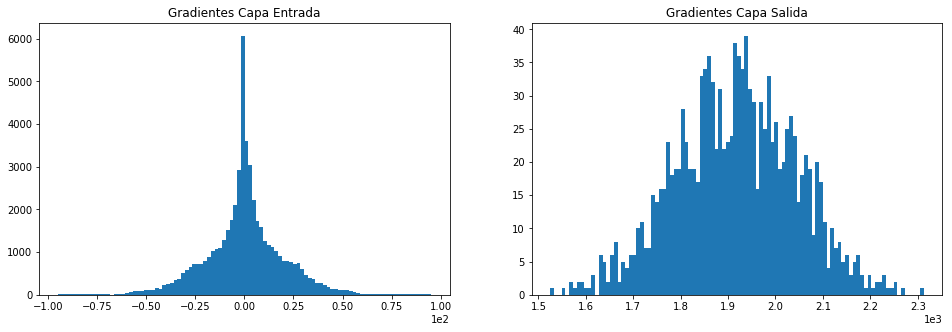

In [126]:
create_gradients_graphs(param=1)

In [0]:
hist_1 = model.fit(X_train_scaled, y_train, epochs=50, verbose=0, validation_data=(X_val_scaled, y_val))

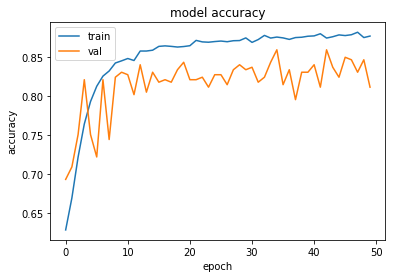

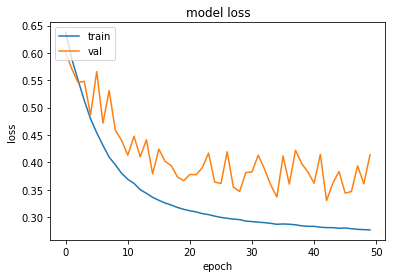

In [128]:
plot_graphs(hist_1)

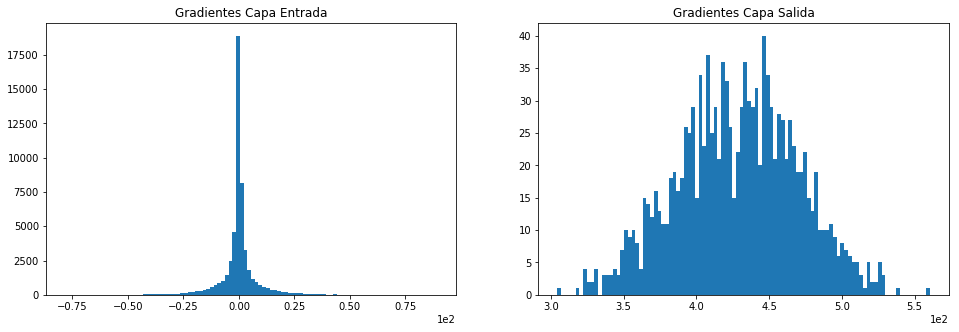

In [129]:
create_gradients_graphs(param=1)

Los gradientes en ambos casos se reducen en un orden de magnitud desde la capa de entrada a la capa de salida, antes y déspues del entrenamiento. Otra caracteristica observable en los gráficos es el aumento de magnitud en los gradientes de la capa de entreda luego de ser entrenada. Por otra parte se puede apreciar que los valores en la capa de entrada se encuentran centrados en cero, en cambio para la capa de salida no estan centrados en cero, para los gradientes antes de entrenamiento se encuentran entre 1.6 y 2.6, en cambio para luego del entrenamiento se encuentran entre 4 y 8.

**b)** Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red con los mimos pesos distribuidos a través de muchas más capas (red profunda de 6 capas), 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar. ¿Qué sucede con la *loss*? ¿El modelo logra aprender?

In [0]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

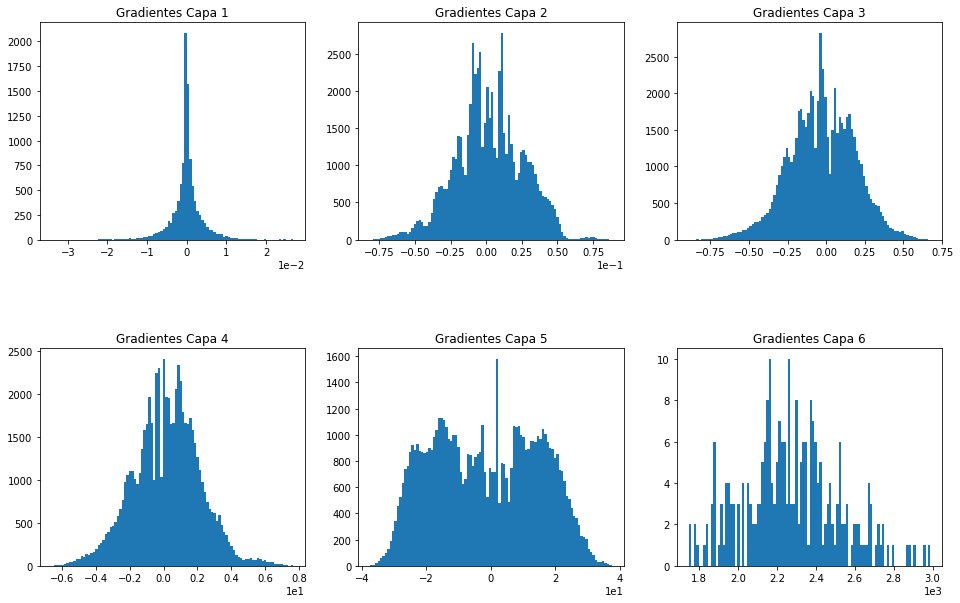

In [131]:
create_gradients_graphs()

In [0]:
hist_2 = model.fit(X_train_scaled, y_train, epochs=50, verbose=0, validation_data=(X_val_scaled, y_val))

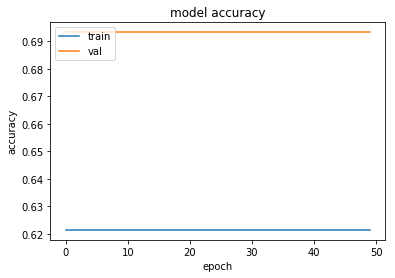

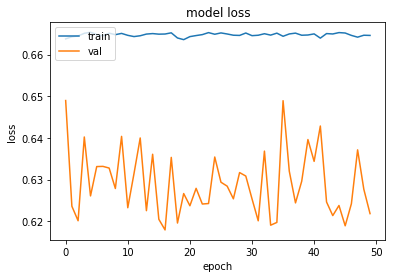

In [133]:
plot_graphs(hist_2)

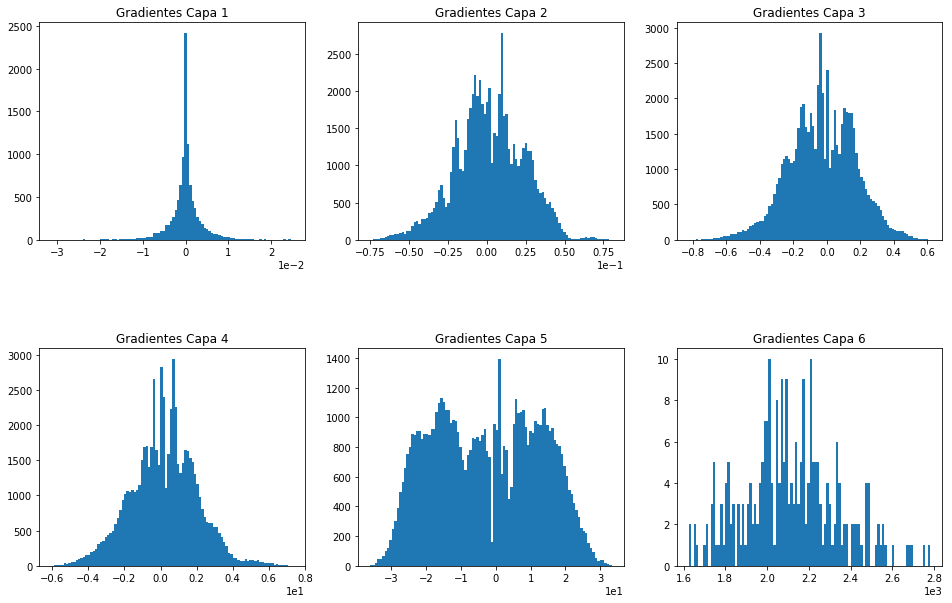

In [134]:
create_gradients_graphs()

**c)** Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[6]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar. ¿Qué sucede ahora con la *loss*? ¿El modelo logra aprender?

In [0]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy',  metrics=['accuracy'])

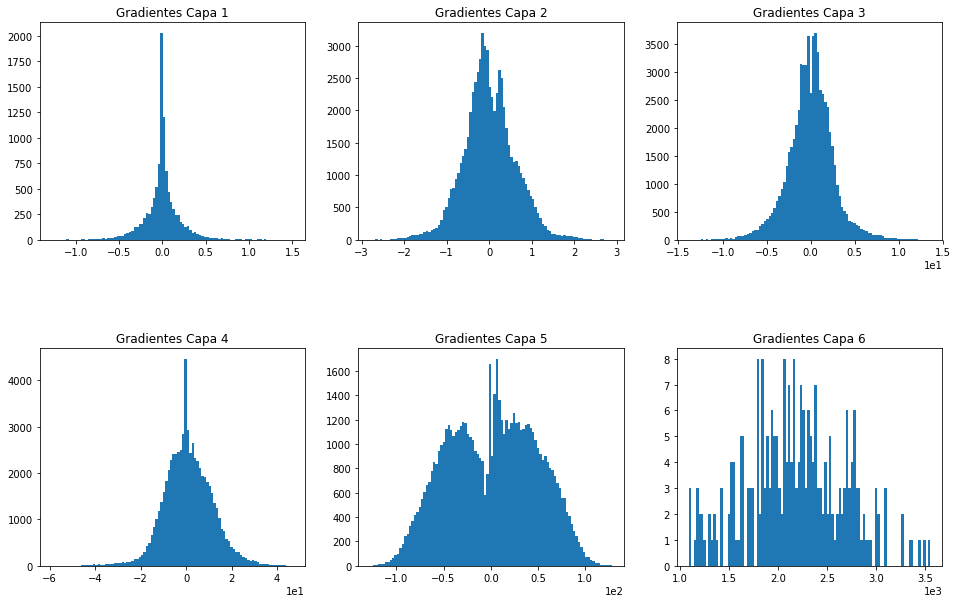

In [136]:
create_gradients_graphs()

In [0]:
hist_3 = model.fit(X_train_scaled, y_train, epochs=50, verbose=0, validation_data=(X_val_scaled, y_val))

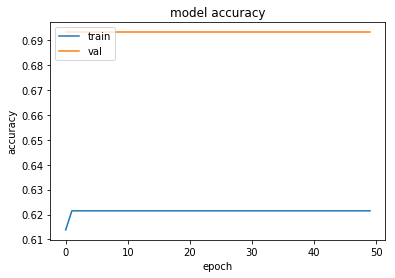

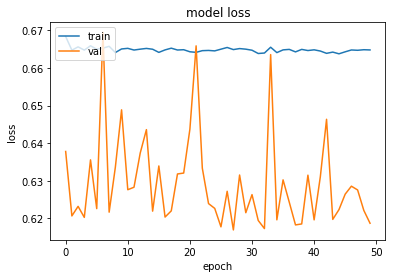

In [138]:
plot_graphs(hist_3)

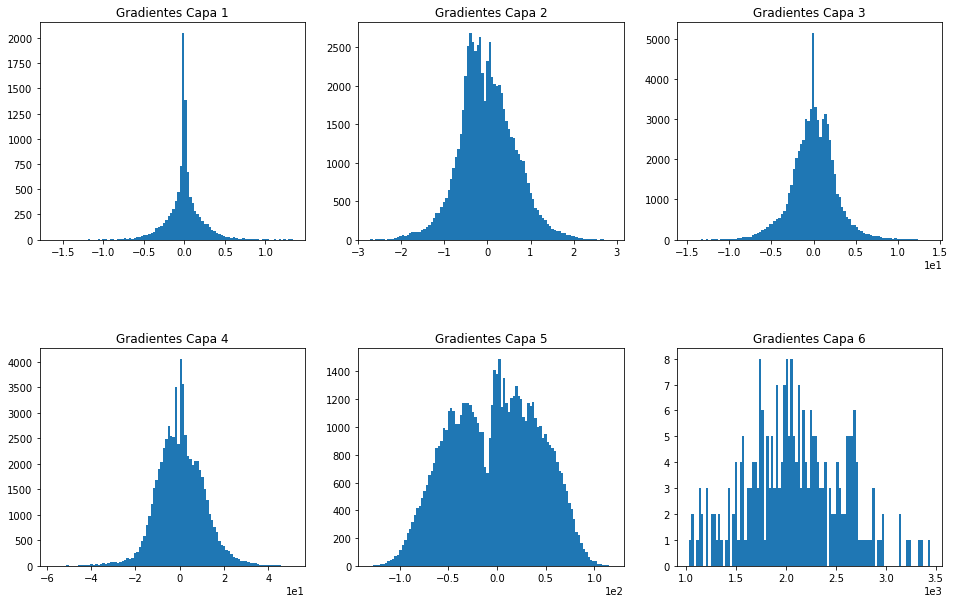

In [139]:
create_gradients_graphs()

**d)** Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform*, y comparar con la inicialización de He [[7]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura. 

In [0]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu')) #uniform
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='relu'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

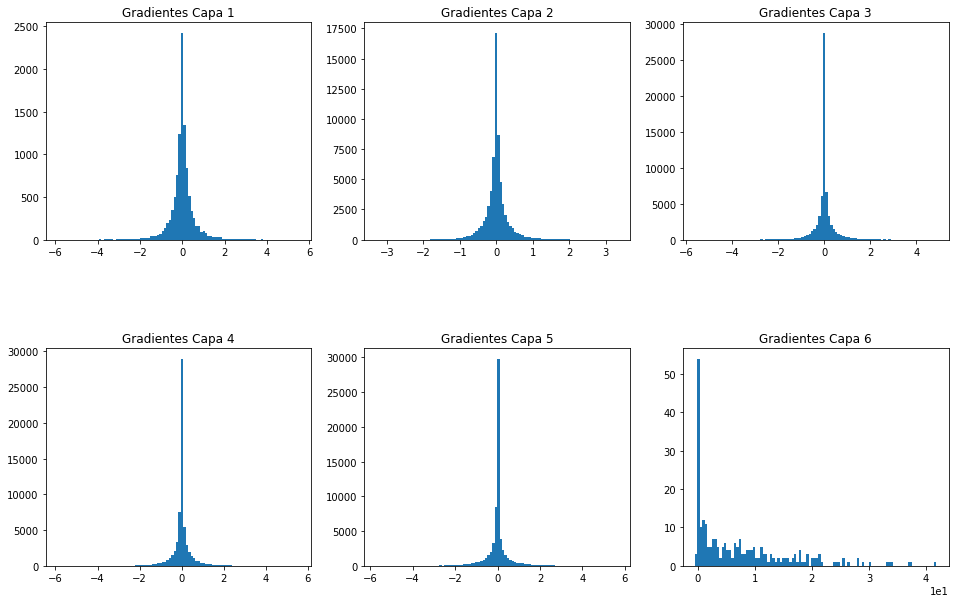

In [141]:
create_gradients_graphs()

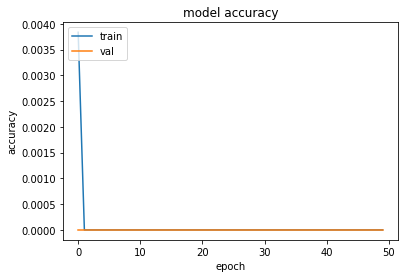

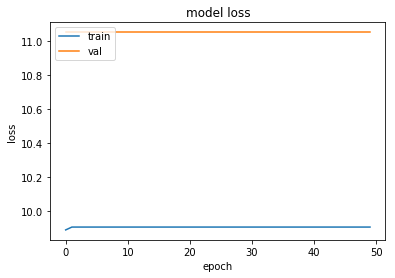

In [142]:
hist_4 = model.fit(X_train_scaled, y_train, epochs=50, verbose=0, validation_data=(X_val_scaled, y_val))
plot_graphs(hist_4)

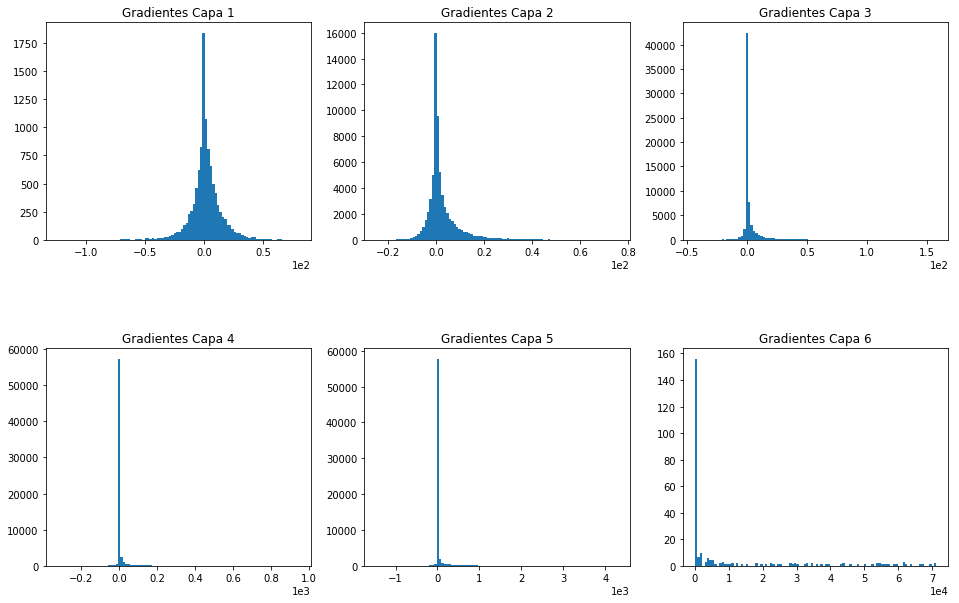

In [143]:
create_gradients_graphs()

In [0]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='relu'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

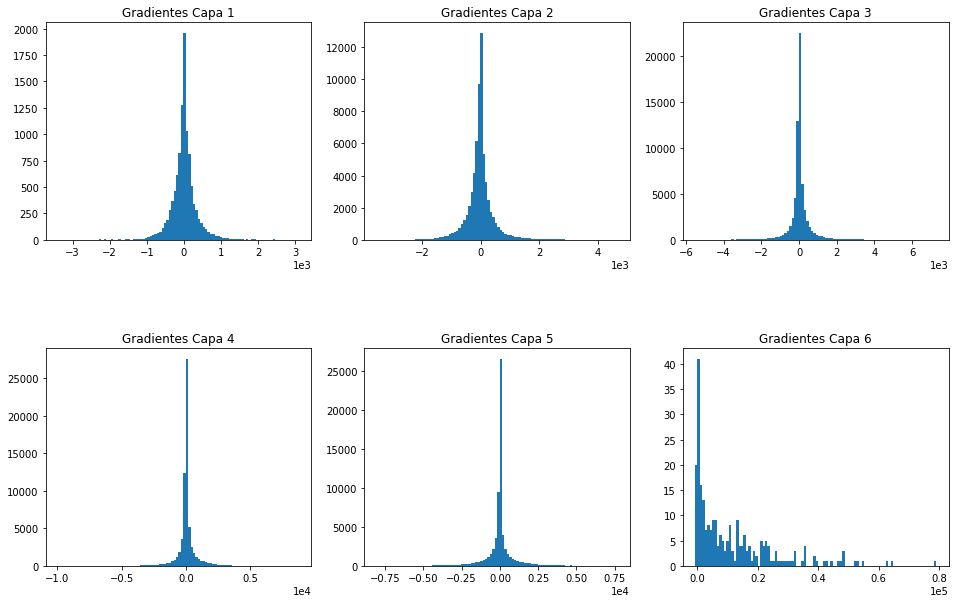

In [146]:
create_gradients_graphs()

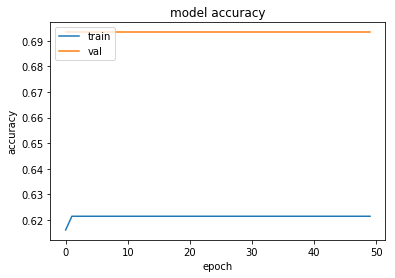

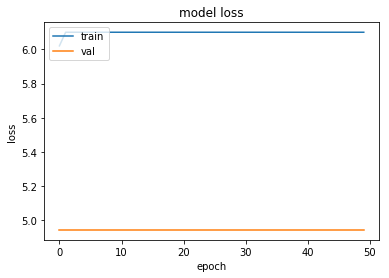

In [147]:
hist_5 = model.fit(X_train_scaled, y_train, epochs=50, verbose=0, validation_data=(X_val_scaled, y_val))
plot_graphs(hist_5)

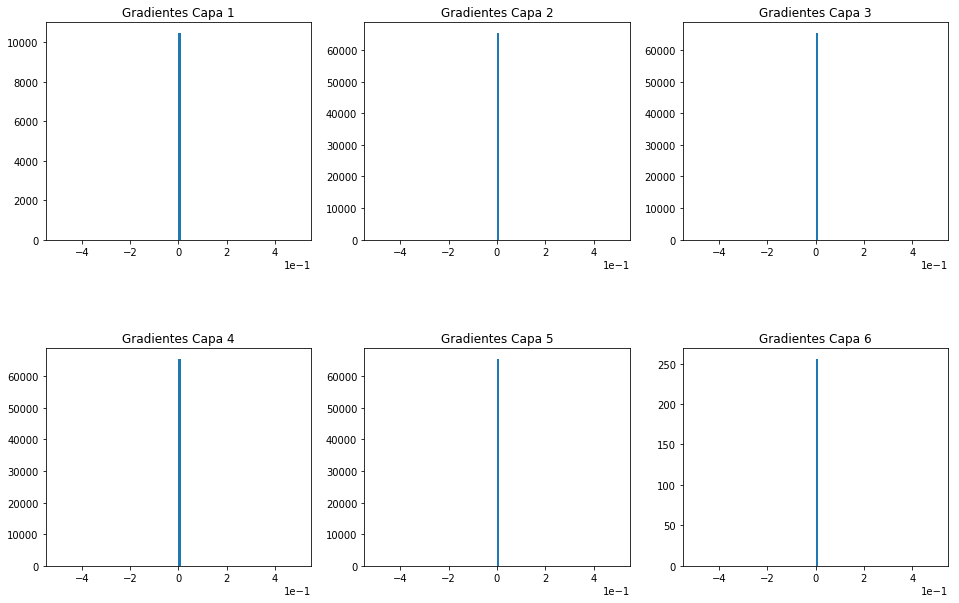

In [148]:
create_gradients_graphs()

**e)** Experimente con la utilización de una función activación auxiliar (debido a que aproxima) a '**ReLU**' y que es continua derivable (**softplus**) ¿Cuál es el beneficio de ésta con respecto ReLU? Comente.

In [0]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='softplus'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

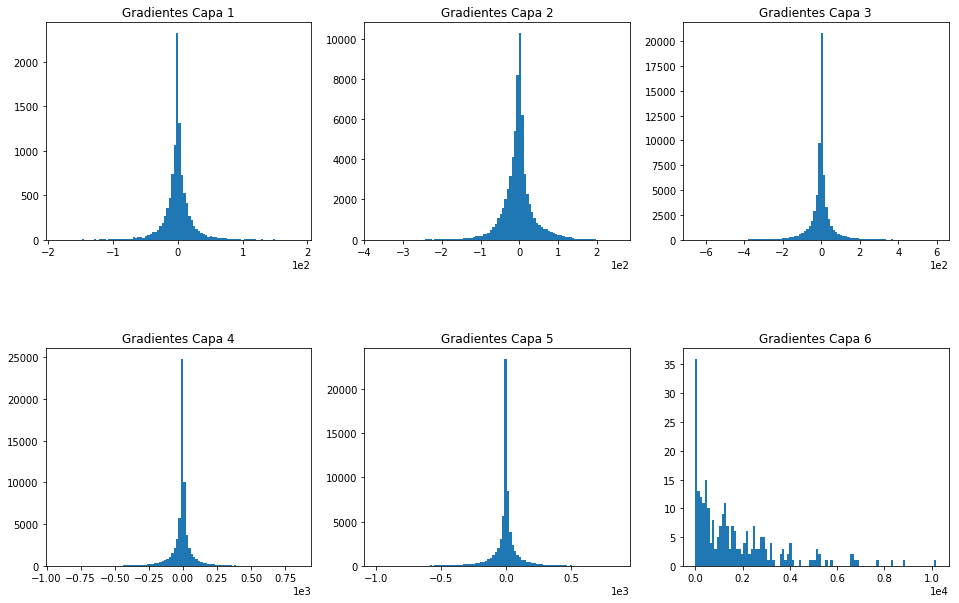

In [157]:
create_gradients_graphs()

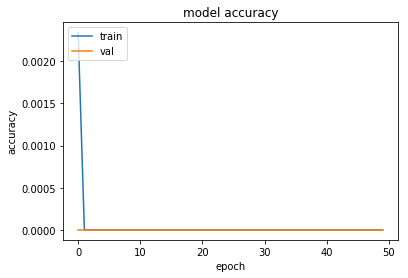

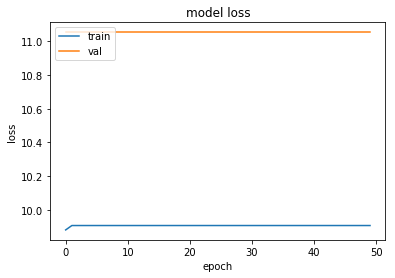

In [158]:
hist_6 = model.fit(X_train_scaled, y_train, epochs=50, verbose=0, validation_data=(X_val_scaled, y_val))
plot_graphs(hist_6)

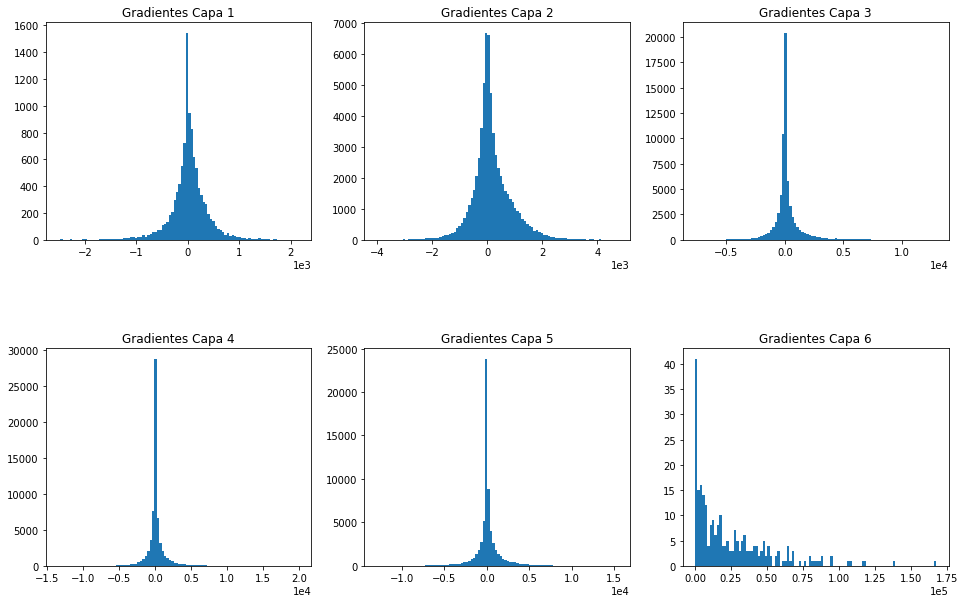

In [159]:
create_gradients_graphs()

**f)** ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Vuelva a experimentar con variar las funciones de activación con el propósito de lograr un buen aprendizaje y generalización del modelo en base a la *loss*. Experimente con la familia ReLU (LeakyReLU, PReLU, ELU, ThresholdedReLU), algunas en el __[link](https://keras.io/layers/advanced-activations/)__. ¿Con cuál se aprende más rápido en términos de la *loss*? Además monitoree neuronas muertas (*dying neuron*) a través de los valores de la activación (por ejemplo ReLU con valor 0 no genera gradiente) con un histograma a lo largo del entrenamiento.  
*Hint: ésto último se puede visualizar con lo de la pregunta b), __[TensorBoard](https://keras.io/callbacks/#tensorboard)__*.

¿Las funciones de activaciones de cada capa necesariamente deben ser iguales? Comente sobre su respuesta.

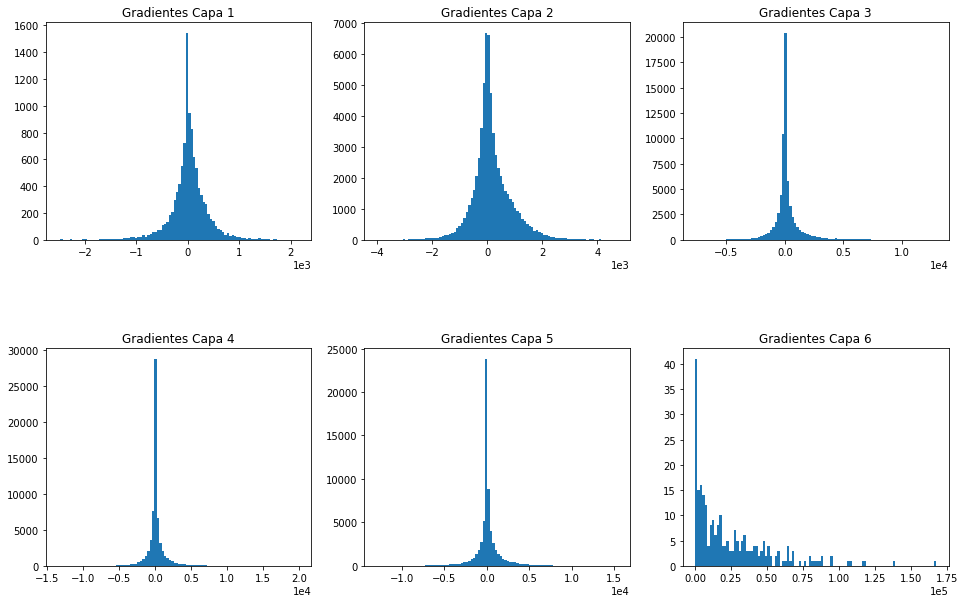

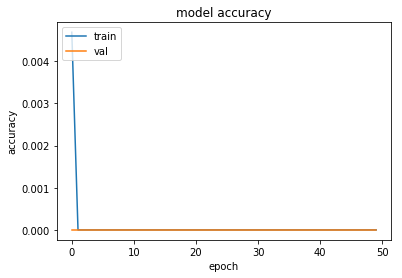

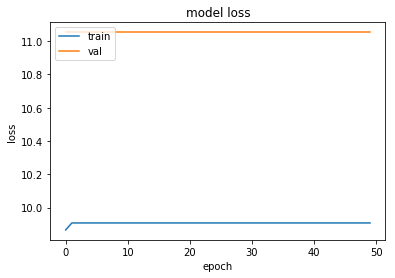

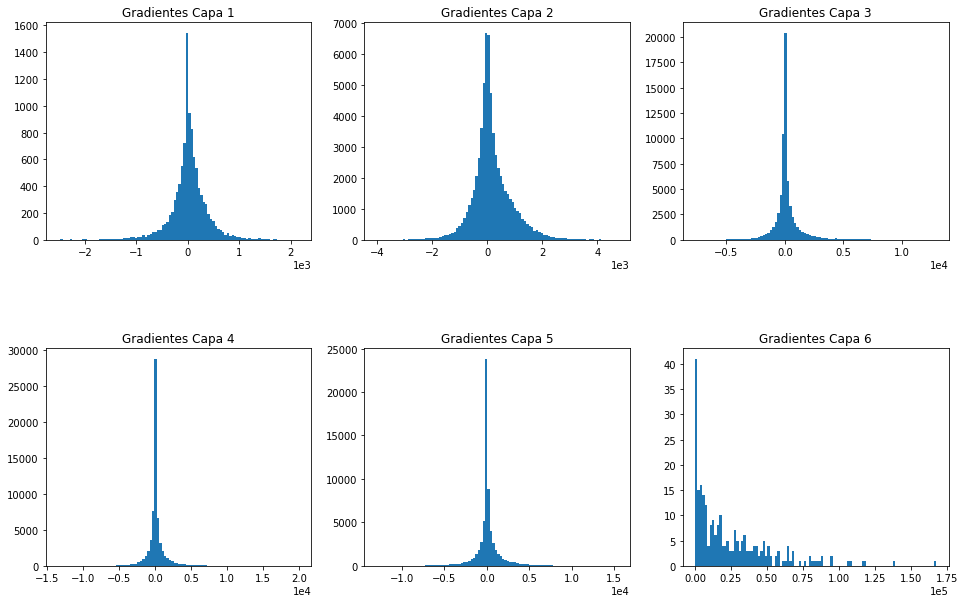

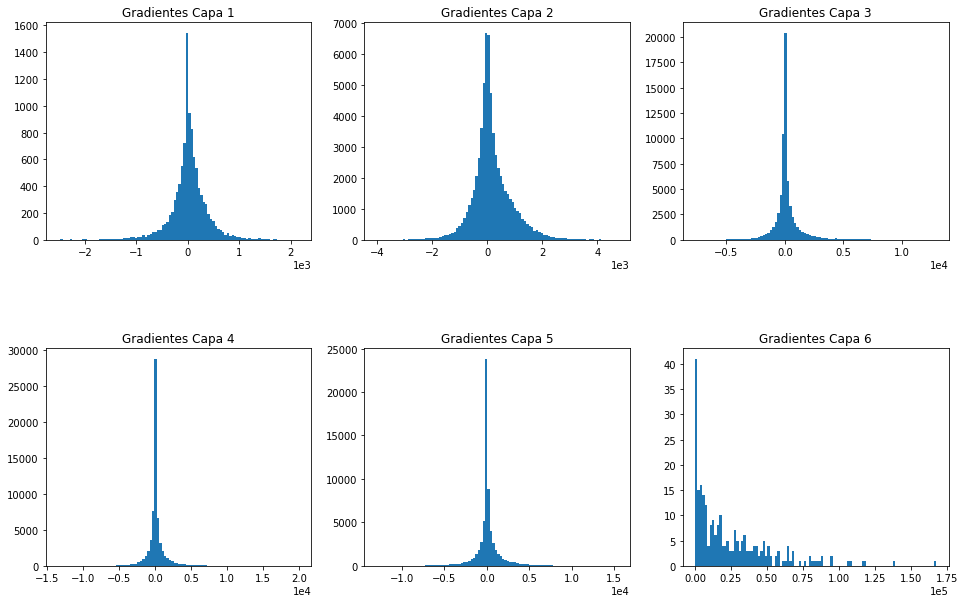

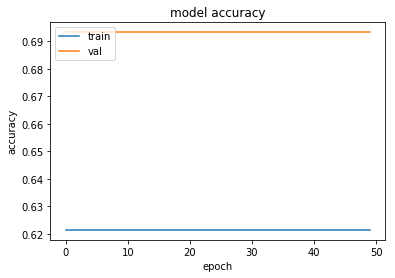

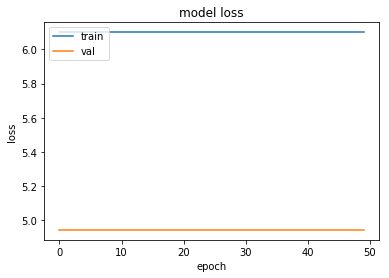

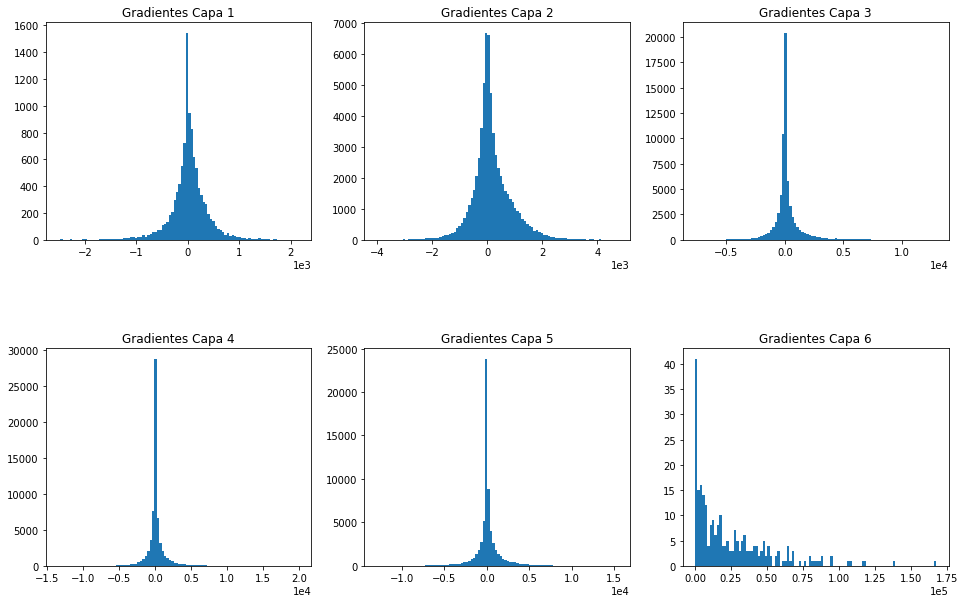

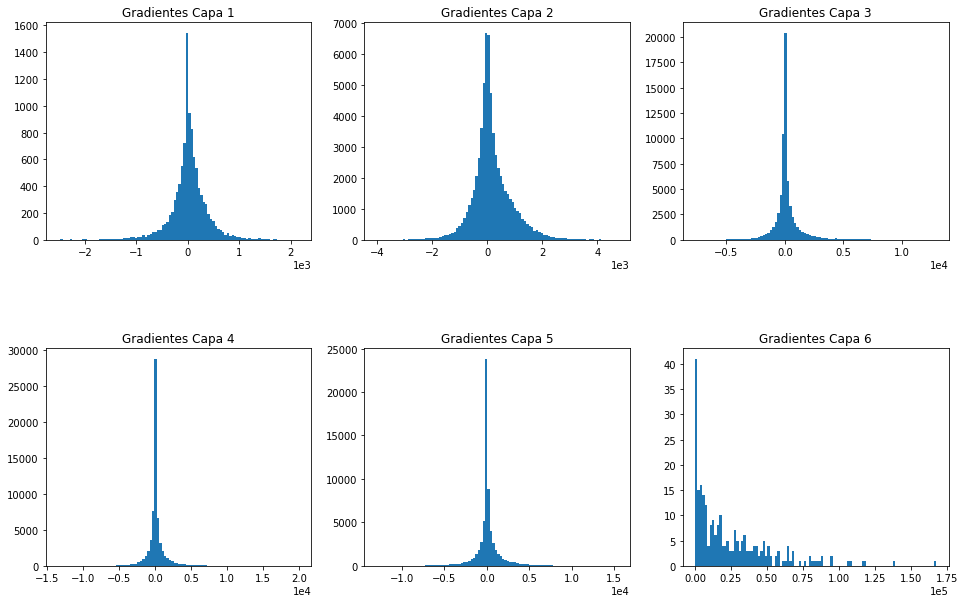

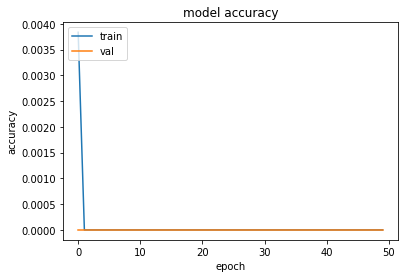

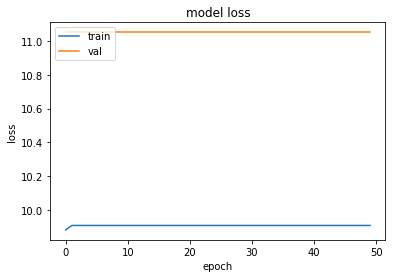

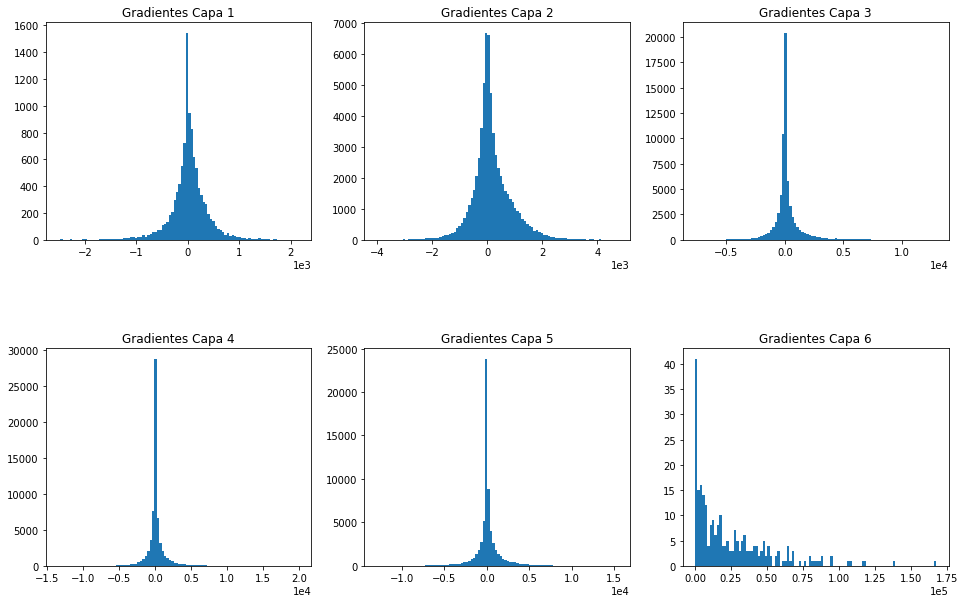

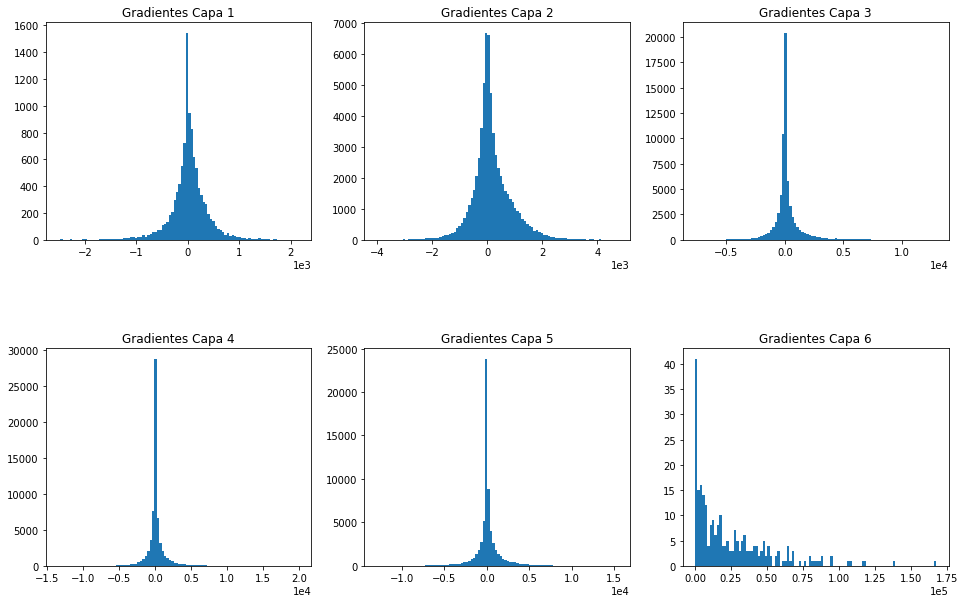

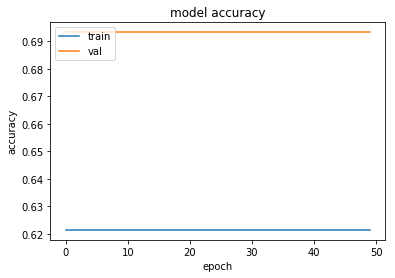

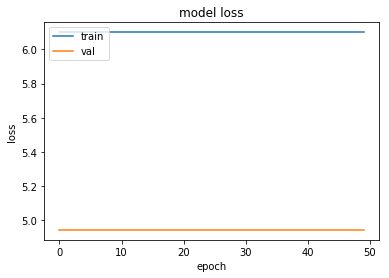

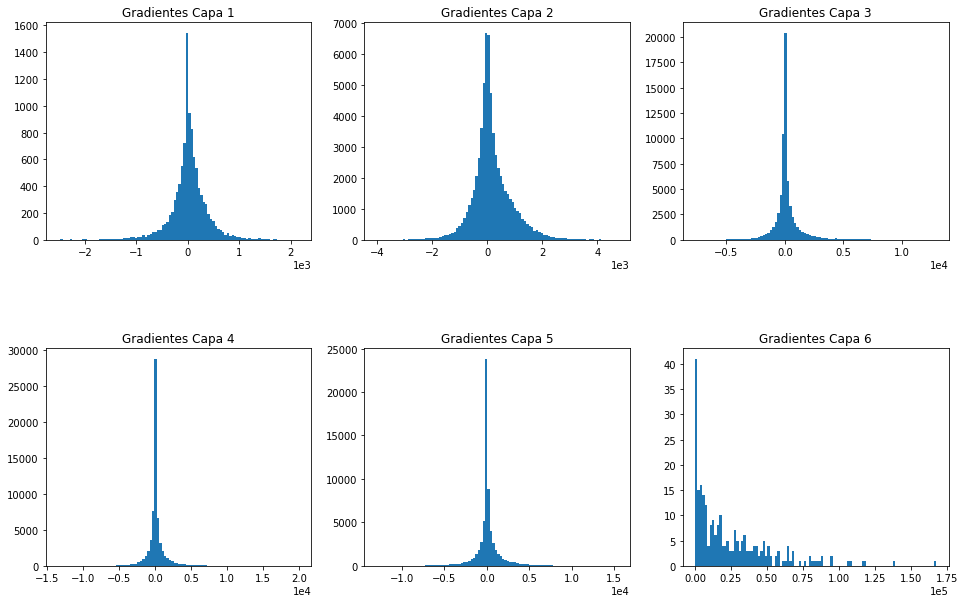

In [160]:
from keras.layers import LeakyReLU, PReLU, ELU, ThresholdedReLU
activaciones= [LeakyReLU(alpha=0.3), PReLU(alpha_initializer='zeros'), ELU(alpha=1.0), ThresholdedReLU(theta=1.0) ]

def generate_model(activaciones):
  for i in activaciones:
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')), model.add(i)
    model.add(Dense(256, kernel_initializer='uniform')), model.add(i)
    model.add(Dense(256, kernel_initializer='uniform')), model.add(i)
    model.add(Dense(256, kernel_initializer='uniform')), model.add(i)
    model.add(Dense(256, kernel_initializer='uniform')), model.add(i)
    model.add(Dense(1, kernel_initializer='uniform')), model.add(i)
    model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    create_gradients_graphs()
    hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=0, validation_data=(X_val_scaled, y_val))
    plot_graphs(hist)
    create_gradients_graphs()
    
    
generate_model(activaciones)

**g)** Ahora, sin variar la profundidad de la red definida en b), se pedirá que experimente con otra variación que podría resultar provechoso para la generalización y aprendizaje del modelo, la técnica de *Dropout* [[8]](#refs) y la técnica de *Batch Normalization*[[9]](#refs). Decida si colocarlas en todas las capas o en algunas. Comente sobre el efecto esperado y el observado.

In [0]:
from keras.layers import Dropout, BatchNormalization

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


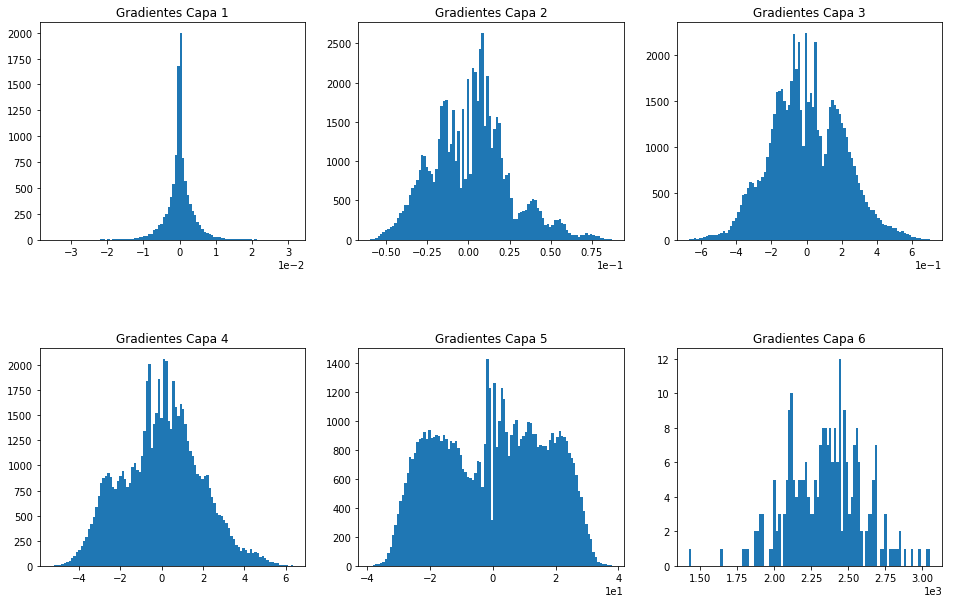

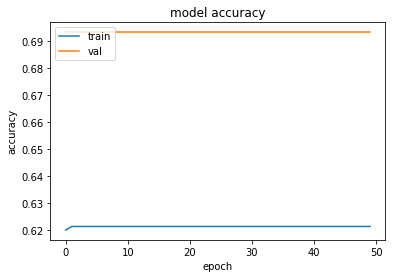

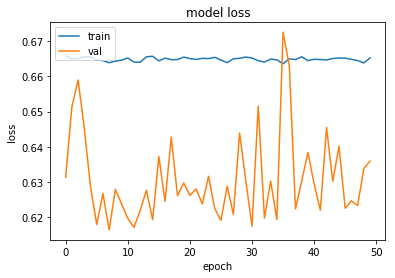

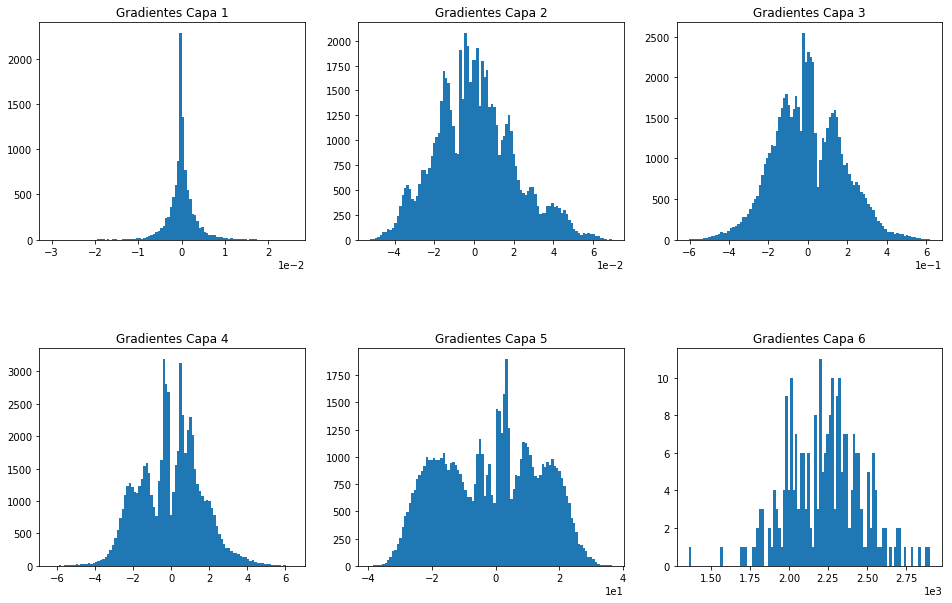

In [162]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

create_gradients_graphs()
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=0, validation_data=(X_val_scaled, y_val))
plot_graphs(hist)
create_gradients_graphs()

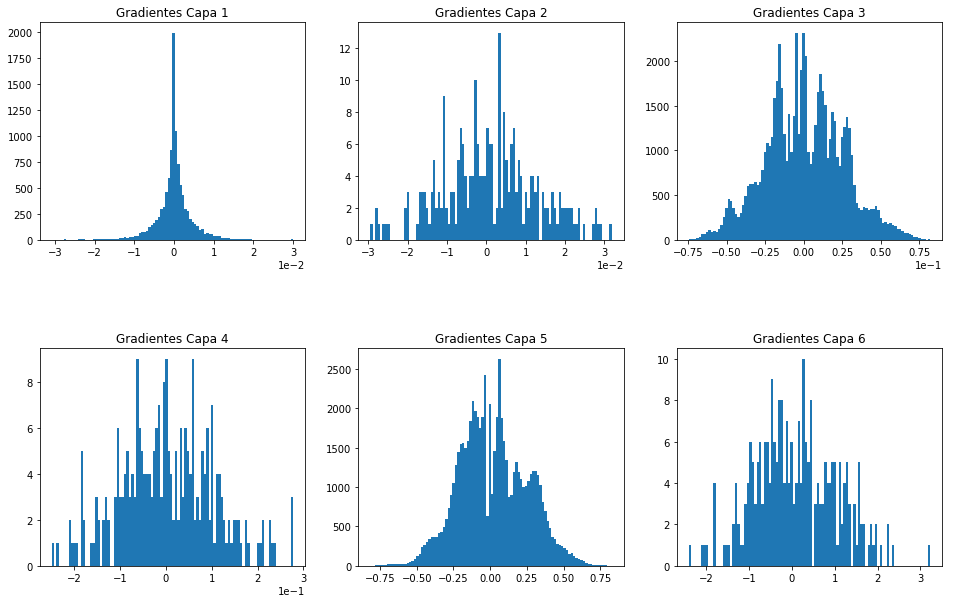

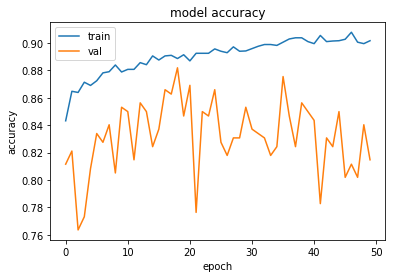

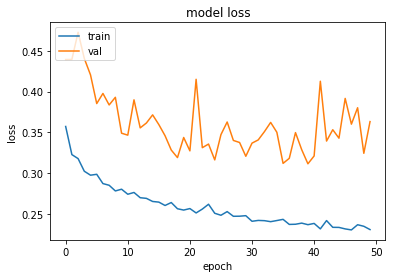

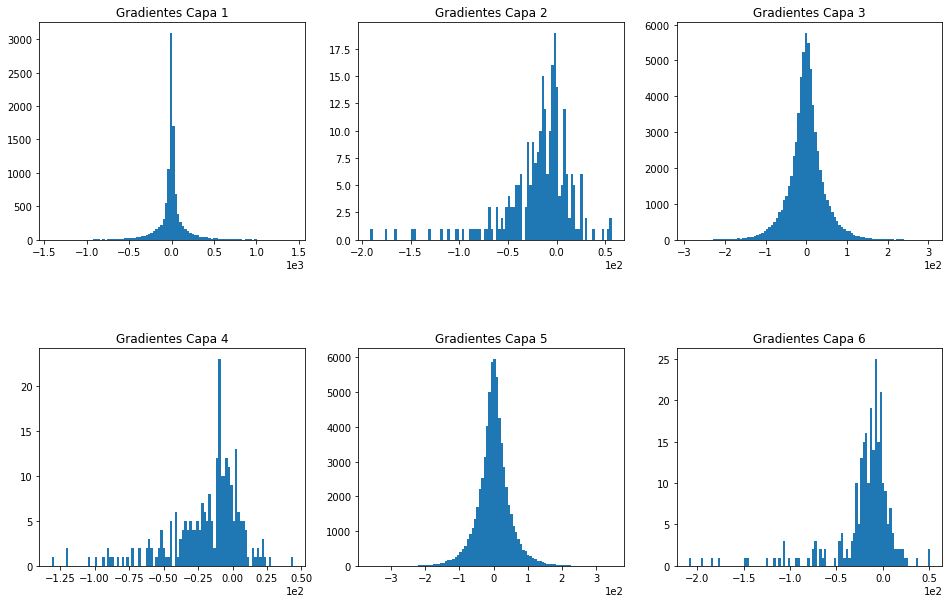

In [163]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

create_gradients_graphs()
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=0, validation_data=(X_val_scaled, y_val))
plot_graphs(hist)
create_gradients_graphs()

<a id="refs"></a>
## Referencias
[1] Borucki, W. J., Koch, D. G., Basri, G., Batalha, N., Boss, A., Brown, T. M., ... & Dunham, E. W. (2011). *Characteristics of Kepler planetary candidates based on the first data set*. The Astrophysical Journal, 728(2), 117. also in: https://exoplanetarchive.ipac.caltech.edu/index.html  
[2] Bugueno, M., Mena, F., & Araya, M. *Refining Exoplanet Detection Using Supervised Learning and Feature Engineering*.  
[3] Sutskever, I., Martens, J., Dahl, G. E., & Hinton, G. E. (2013). *On the importance of initialization and momentum in deep learning*. ICML (3), 28(1139-1147), 5.  
[4] Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). *Focal loss for dense object detection*. In Proceedings of the IEEE international conference on computer vision (pp. 2980-2988).  
[5] Chen, P., Chen, Y., & Rao, M. (2008). *Metrics defined by Bregman divergences: Part 2*. Communications in Mathematical Sciences, 6(4), 927-948.  
[6] Glorot, X., & Bengio, Y. (2010, March). *Understanding the difficulty of training deep feedforward neural networks*. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).   
[7] He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving deep into rectifiers: Surpassing human-level performance on imagenet classification*. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).    
[8] Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). *Dropout: a simple way to prevent neural networks from overfitting*. The Journal of Machine Learning Research, 15(1), 1929-1958.  
[9] Ioffe, S., & Szegedy, C. (2015). Batch normalization: *Accelerating deep network training by reducing internal covariate shift*. arXiv preprint arXiv:1502.03167.  
[10] Krizhevsky, A., Nair, V., & Hinton, G. (2014). *The CIFAR-10 dataset*. online: http://www.cs.toronto.edu/kriz/cifar.html , 4.  
[11] Bengio, Y. (2012, June). *Deep learning of representations for unsupervised and transfer learning*. In Proceedings of ICML Workshop on Unsupervised and Transfer Learning (pp. 17-36).  
[12] Simonyan, K., & Zisserman, A. (2014). *Very deep convolutional networks for large-scale image recognition*. arXiv preprint arXiv:1409.1556.  
[13] Ruder, S. (2017). *An overview of multi-task learning in deep neural networks*. arXiv preprint arXiv:1706.05098.  